[View in Colaboratory](https://colab.research.google.com/github/hogezero/cifar10/blob/master/cifar10.ipynb)

# chainer セットアップ

In [0]:
# chainerセットアップ
# https://qiita.com/keisuke-umezawa/items/4e99c2a4f5f07567444c

# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'
!apt-get install graphviz
!pip install 'chaineripy'

# 必要なものをインポート

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# chainer
import numpy as np
import chainer
from chainer import training
from chainer import iterators, optimizers, serializers
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import split_dataset
import pandas as pd
pd.options.display.precision = 3      # pandasの有効桁数を指定

**GPU確認**

In [107]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


# データセット
**データセット取得 (CIFAR-10)**

In [0]:
(train_original, test_original) = chainer.datasets.get_cifar10()

**データセット分割**

In [0]:
train, test = split_dataset(train_original, int(len(train_original) * 0.8))

**ラベルの名前**

In [0]:
# ラベルの名前
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

**CIFAR-10学習画像表示**

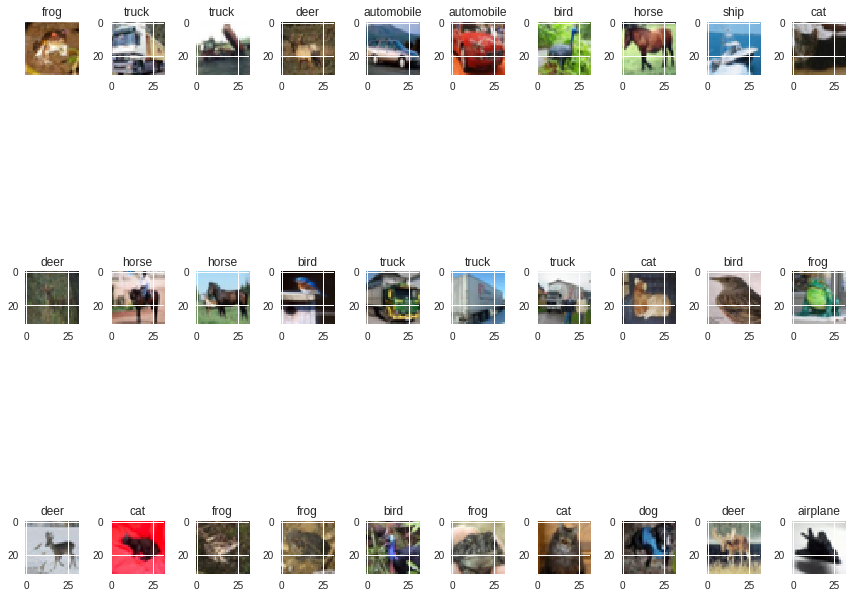

In [111]:

plt.rcParams['figure.figsize'] = (12.0,12.0)
fig,ax = plt.subplots(nrows=3,ncols=10)
ax = ax.flatten()
for i in range(30):
    img = train[i][0]
    newimg = np.dstack((img[0],img[1],img[2]))
    ax[i].imshow(newimg,interpolation='none')
    ax[i].title.set_text(cifar10_labels[train[i][1]])
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


## データセットの構成

**学習用データ**

In [112]:
print('train total data : {:<5}'.format(len(train)))
print("-------------------------------------------------------------")
train_category = []
for data, label_number in train:
    train_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = train_category.count(number)
  print("{:<15} :{:>4}".format(name, num))

train total data : 40000
-------------------------------------------------------------
airplane        :3986
automobile      :3986
bird            :4048
cat             :3984
deer            :4003
dog             :3975
frog            :4020
horse           :4023
ship            :3997
truck           :3978


**検証用データ**

In [113]:
print('test total data  : {:<5}'.format(len(test)))
print('-------------------------------------------------------------')
test_category = []
for data, label_number in test:
    test_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = test_category.count(number)
  print("{:<15} : {:>4}".format(name, num))

test total data  : 10000
-------------------------------------------------------------
airplane        : 1014
automobile      : 1014
bird            :  952
cat             : 1016
deer            :  997
dog             : 1025
frog            :  980
horse           :  977
ship            : 1003
truck           : 1022


**データとラベルのclassを確認**

In [114]:
print(type(train[0][0]))
print(type(train[0][1]))

<class 'numpy.ndarray'>
<class 'numpy.int32'>


# 学習

## AlexNet
**モデル定義**

In [0]:
class AlexNet(chainer.Chain):
    def __init__(self, num_class, train=True):
        super(AlexNet, self).__init__()
        with self.init_scope():
            self.conv1=L.Convolution2D(None, 96, 11, stride=2)
            self.conv2=L.Convolution2D(None, 256, 5, pad=2)
            self.conv3=L.Convolution2D(None, 384, 3, pad=1)
            self.conv4=L.Convolution2D(None, 384, 3, pad=1)
            self.conv5=L.Convolution2D(None, 256, 3, pad=1)
            self.fc6=L.Linear(None, 4096)
            self.fc7=L.Linear(None, 4096)
            self.fc8=L.Linear(None, num_class)

    def __call__(self, x):
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv1(x))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        h = self.fc8(h)

        return h

In [0]:
model = L.Classifier(AlexNet(len(cifar10_labels)))


**GPU使用**

In [0]:
#GPU
gpu_id = 0
if gpu_id >= 0:
  model.to_gpu(gpu_id)

In [0]:
optimizer = optimizers.MomentumSGD()
optimizer.setup(model)

In [0]:
batchsize = 20
max_epoch = 50
mytrigger = 10
train_iter = iterators.SerialIterator(train, batchsize)
test_iter  = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# iteration回数またはepochの回数を定義 #
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss', out_name="cg.dot"))
# snapshotする間隔を決める #
trainer.extend(extensions.snapshot(filename='snapshot_iter_{.updater.epoch}'), trigger=(mytrigger, 'epoch'))
# modelの保存 #
trainer.extend(extensions.snapshot_object(model, 'model_snapshot_{.updater.epoch}', savefun=serializers.save_npz), trigger=(mytrigger, 'epoch'))
trainer.extend(extensions.LogReport())      # lossを 1 epochごとに出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png', marker=""))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png', marker=""))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
#trainer.extend(extensions.ProgressBar(update_interval=1))


**学習開始**

In [121]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.84538     0.296475       1.61224               0.3956                    74.8138       
2           1.50866     0.4442         1.4629                0.4604                    150.15        
3           1.35127     0.509925       1.28969               0.543                     225.158       
4           1.22643     0.561825       1.25068               0.5633                    300.178       
5           1.12162     0.604025       1.1666                0.5978                    375.275       
6           1.02373     0.6405         1.10126               0.6216                    450.566       
7           0.932566    0.674375       1.10673               0.6217                    525.604       
8           0.845334    0.70265        1.03815               0.6462                    600.771       
9           0.767105    0.730999       1.06157               0.6533                 

43          0.044049    0.985621       1.98704               0.6745                    3269.73       
44          0.0367864   0.988297       2.01923               0.6788                    3344.22       
45          0.039387    0.987146       2.17276               0.668                     3418.91       
46          0.0355962   0.988797       2.01494               0.6722                    3493.3        
47          0.0400191   0.987872       2.35774               0.6651                    3567.71       
48          0.0404167   0.987847       2.15053               0.6807                    3642.46       
49          0.0385452   0.988321       2.13197               0.6667                    3716.85       
50          0.0357084   0.988597       2.21429               0.6771                    3791.51       


**モデル保存**

In [122]:
print('save the model')
serializers.save_npz('./result/end.model', model)

save the model


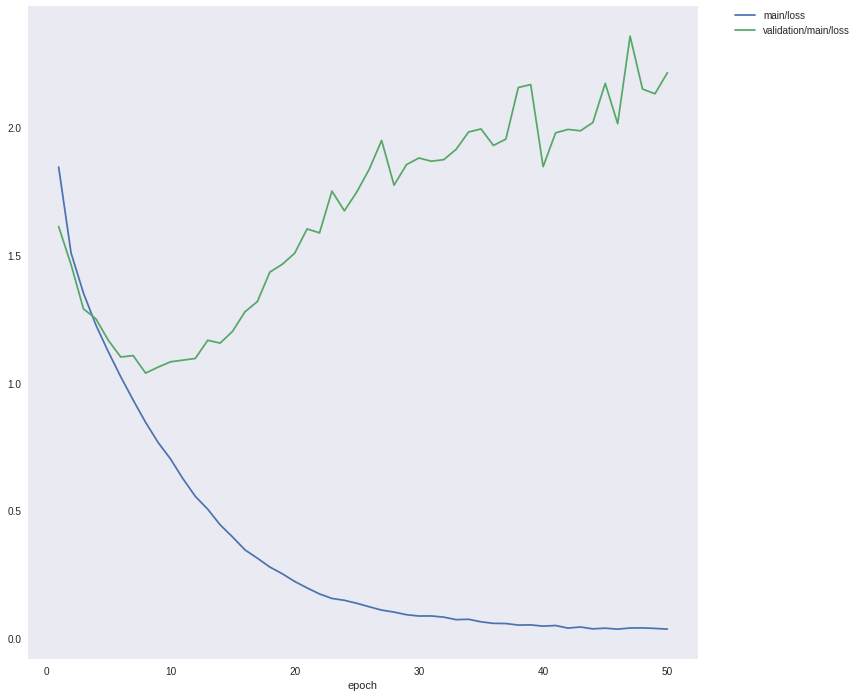

In [123]:
from IPython.display import Image
Image('result/loss.png')

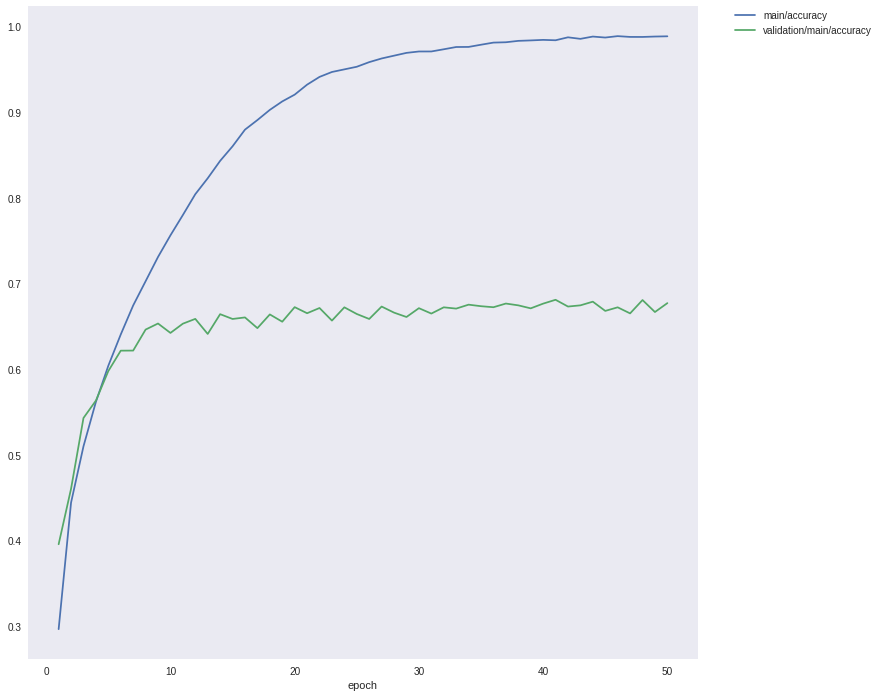

In [124]:
Image('result/accuracy.png')

**ネットワークモデル図**

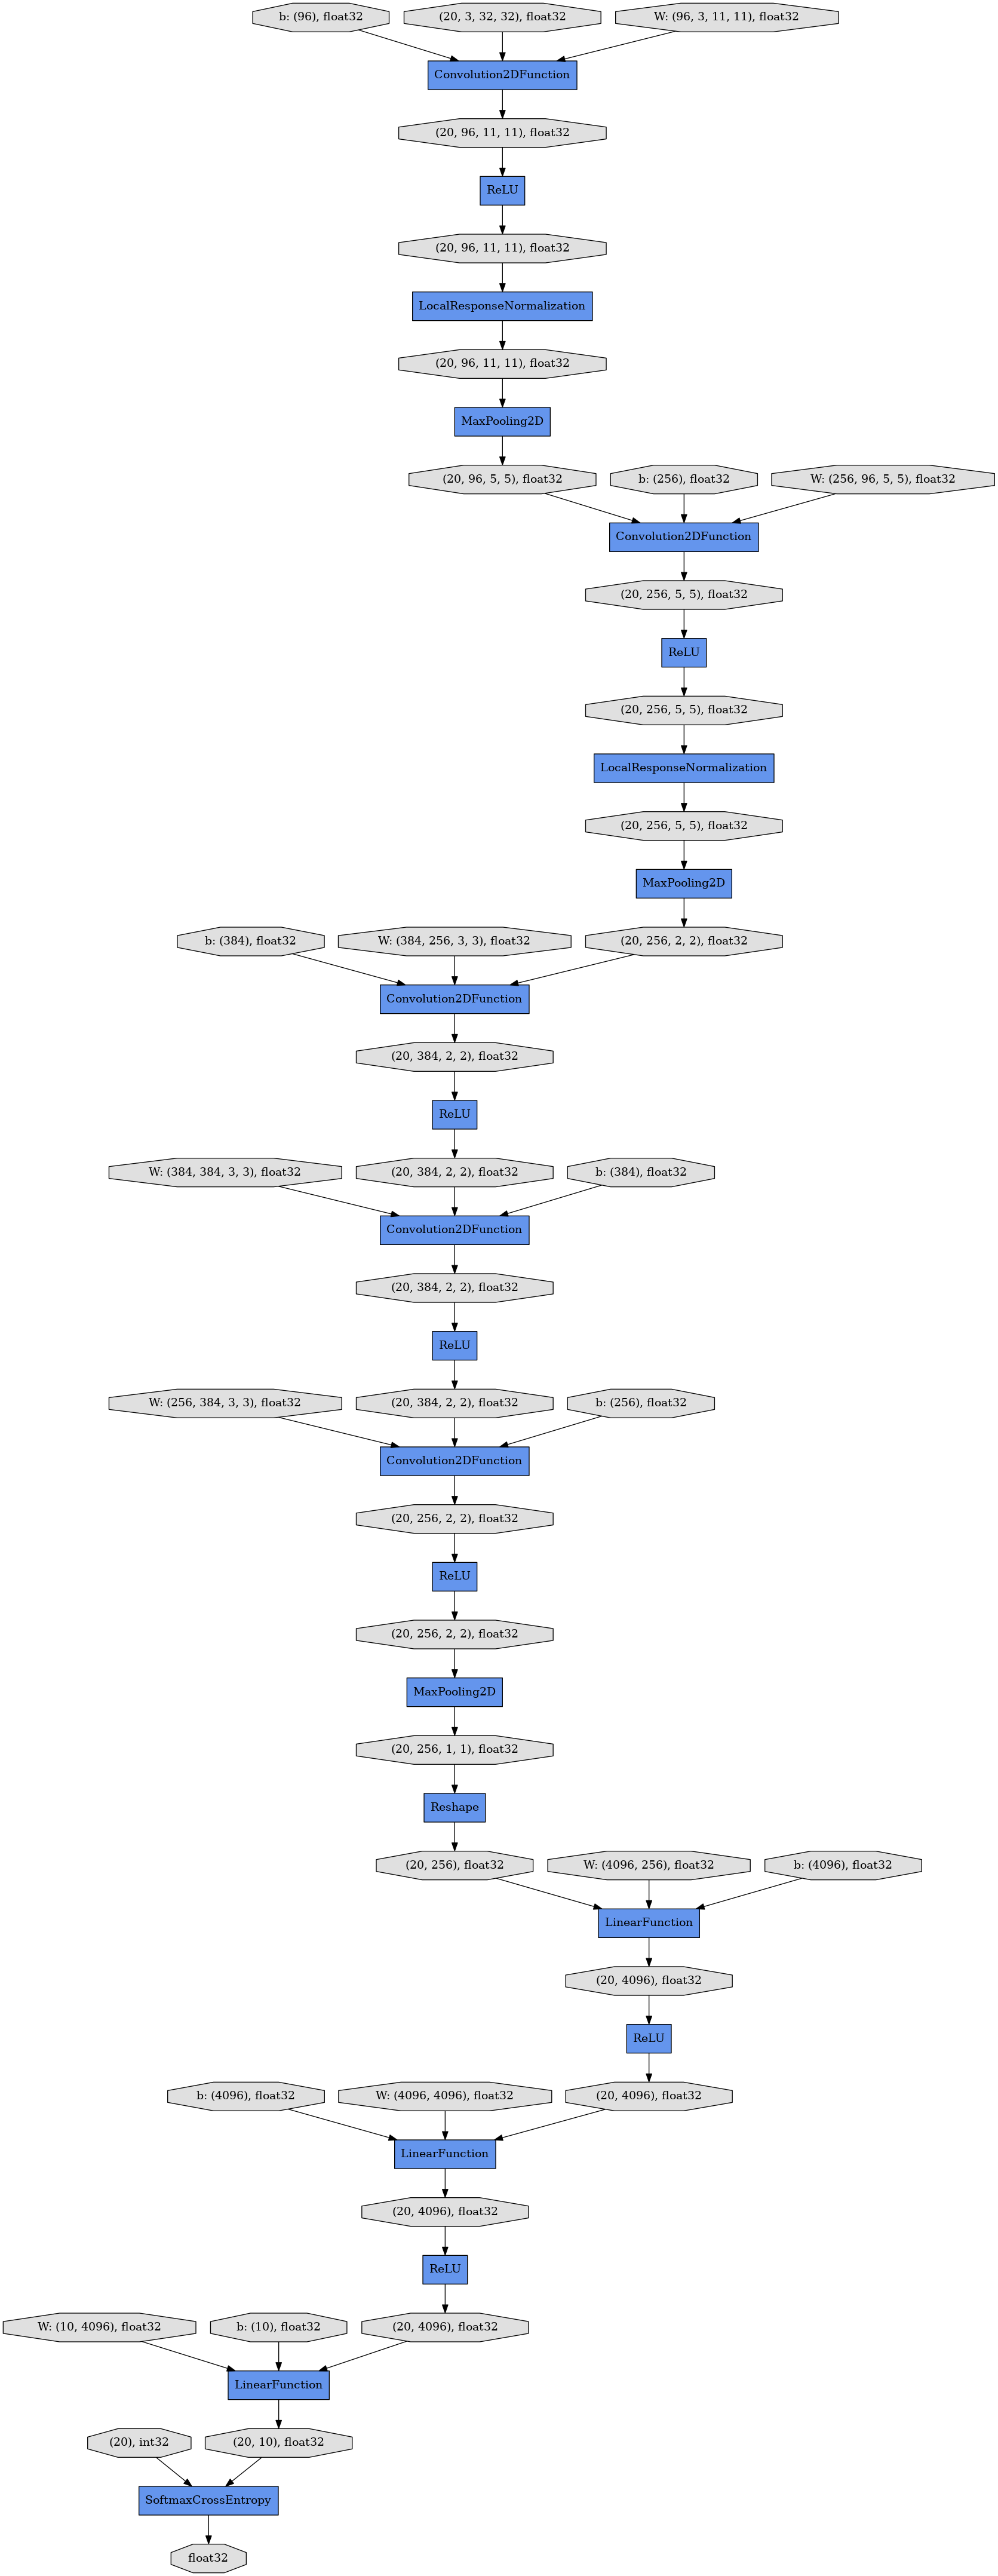

In [125]:
!dot -Tpng result/cg.dot -o result/net.png
Image('result/net.png', width=1500, height=2000)

# テスト (学習済みモデルを呼び出す)

**モデルの保存先を確認**

In [126]:
!ls result/

accuracy.png  loss.png		 model_snapshot_40  snapshot_iter_20
cg.dot	      model_snapshot_10  model_snapshot_50  snapshot_iter_30
end.model     model_snapshot_20  net.png	    snapshot_iter_40
log	      model_snapshot_30  snapshot_iter_10   snapshot_iter_50


In [0]:
chainer.config.train = False
test_model =L.Classifier(AlexNet(len(cifar10_labels), train=False))

In [0]:
serializers.load_npz("./result/end.model", test_model)

In [0]:
test_num = 10000
test_label = []
pred = []
ok = []
no = []
for data, label in test_original[0:test_num][0:test_num]:
  test_label.append(label)
  redata = np.reshape(data, (1, 3, 32, 32))
  x = test_model.predictor(redata)
  cls = F.argmax(x)
  pred.append(cls.data.tolist())
  if(cls.data == label):
    ok.append(label)
  else:
    no.append(label)
  #x = test_model.predictor(redata)

In [130]:
print('total ok data: {}'.format(len(ok)))
for number, name in enumerate(cifar10_labels):
  num = ok.count(number)
  print("{:<15} : {:>4}".format(name, num))

total ok data: 6736
airplane        :  705
automobile      :  757
bird            :  554
cat             :  508
deer            :  643
dog             :  547
frog            :  767
horse           :  733
ship            :  771
truck           :  751


In [131]:
print('total no data: {}'.format(len(no)))
for number, name in enumerate(cifar10_labels):
  num = no.count(number)
  print("{:<15} : {:>4}".format(name, num))

total no data: 3264
airplane        :  295
automobile      :  243
bird            :  446
cat             :  492
deer            :  357
dog             :  453
frog            :  233
horse           :  267
ship            :  229
truck           :  249


In [0]:
df_result = pd.DataFrame(index=[cifar10_labels], columns=['Correct', 'Incorrect', 'Total', 'Accuracy'])

In [0]:
for number, name in enumerate(cifar10_labels):
  df_result['Correct'][name] = ok.count(number)
  df_result['Incorrect'][name] = no.count(number)
  df_result['Total'][name] = total = ok.count(number) + no.count(number)
  df_result['Accuracy'][name] = accuracy = ok.count(number) / total

In [134]:
df_result

,Correct,Incorrect,Total,Accuracy
airplane,705,295,1000,0.705
automobile,757,243,1000,0.757
bird,554,446,1000,0.554
cat,508,492,1000,0.508
deer,643,357,1000,0.643
dog,547,453,1000,0.547
frog,767,233,1000,0.767
horse,733,267,1000,0.733
ship,771,229,1000,0.771
truck,751,249,1000,0.751


In [135]:
from sklearn.metrics import classification_report
performance = classification_report(test_label, pred, target_names=list(cifar10_labels))
print(performance)

             precision    recall  f1-score   support

   airplane       0.75      0.70      0.73      1000
 automobile       0.87      0.76      0.81      1000
       bird       0.58      0.55      0.57      1000
        cat       0.46      0.51      0.48      1000
       deer       0.60      0.64      0.62      1000
        dog       0.58      0.55      0.56      1000
       frog       0.72      0.77      0.75      1000
      horse       0.71      0.73      0.72      1000
       ship       0.81      0.77      0.79      1000
      truck       0.71      0.75      0.73      1000

avg / total       0.68      0.67      0.68     10000

